In [1]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from numba import vectorize, float64, complex128, njit
from classy import Class
import os
import copy
import yaml
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.integrate import quad
from scipy.special import spherical_jn
from time import time
import pybird

In [2]:
font = {'size': 16, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [10.0,6.2]

In [3]:
def corr_from_cov(cov):
    cor = np.empty_like(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            cor[i,j] = cov[i,j]/np.sqrt(cov[i,i]*cov[j,j])
    return cor

In [4]:
class Lkl_bird(object):
    """Likelihood for the power spectrum and wedges."""

    def __init__(self, cosmovec, configdic):
        # CHANGE DATA DIR
        self.data_directory = os.path.join(os.path.expanduser('~'), 'Documents', 'github', 'montepython_public-3.3', 'data')
        
        # self.configfile = configfile
        # self.config = yaml.full_load(open(self.configfile, 'r'))
        self.config = configdic
        
        # Loading data and priors
        options = [ "with_exact_time", "with_tidal_alignments", "with_nnlo_counterterm", "with_nnlo_higher_derivative", 
        "get_chi2_from_marg", "with_derived_bias", "with_quintessence", "with_cf_sys", "xmaxspacing"]

        for keys in options:
            if not keys in self.config: self.config[keys] = False
            print (keys, ':', self.config[keys])
        
        self.x, self.xmask, self.ydata, self.chi2data, self.invcov, self.invcovdata, self.priormat = [], [], [], [], [], [], []
        
        if self.config["skycut"] > 1: self.config["zz"], self.config["nz"] = [], []
        
        self.xmax = 0.
        
        for i in range(self.config["skycut"]):

            if self.config.get("xmax") is None:
                xmax0, xmax1 = self.config["xmax0"][i], self.config["xmax1"][i]
                xmax = max(xmax0, xmax1)
            else: xmax, xmax0, xmax1 = self.config["xmax"][i], None, None

            if self.xmax < xmax: self.xmax = xmax # to increase the kmax to provide to pybird

            if self.config.get("xmin") is None:
                xmin0, xmin1 = self.config["xmin0"][i], self.config["xmin1"][i]
                xmin = min(xmin0, xmin1)
            else: xmin, xmin0, xmin1 = self.config["xmin"][i], None, None

            if self.config["with_bao"]: baoH, baoD = self.config["baoH"][i], self.config["baoD"][i]
            else: baoH, baoD = None, None

            if "Pk" in self.config["output"]:
                xi, xmaski, ydatai, chi2datai, invcovi, invcovdatai = self.__load_data_ps(
                    self.config["multipole"], self.config["wedge"],
                    self.data_directory, self.config["spectrum_file"][i], self.config["covmat_file"][i],
                    xmin=self.config["xmin"][i], xmax=xmax, xmax0=xmax0, xmax1=xmax1, xmaxspacing=self.config["xmaxspacing"], with_bao=self.config["with_bao"], baoH=baoH, baoD=baoD)
            else:
                xi, xmaski, ydatai, chi2datai, invcovi, invcovdatai = self.__load_data_cf(
                    self.config["multipole"], self.config["wedge"],
                    self.data_directory, self.config["spectrum_file"][i], self.config["covmat_file"][i],
                    xmax=self.config["xmax"][i], xmin=xmin, xmin0=xmin0, xmin1=xmin1, with_bao=self.config["with_bao"], baoH=baoH, baoD=baoD)

            priormati = self.__set_prior(self.config["multipole"], model=self.config["model"])
        
            # self.Nx.append(Nxi)
            self.x.append(xi)
            self.xmask.append(xmaski)
            self.ydata.append(ydatai)
            self.chi2data.append(chi2datai)
            self.invcov.append(invcovi)
            self.invcovdata.append(invcovdatai)
            self.priormat.append(priormati)
            
        # formatting configuration for pybird
        self.config["xdata"] = self.x
        if self.config["with_window"]:
            if self.config["skycut"] > 1:
                self.config["windowPk"] = [os.path.join(
                    self.data_directory, self.config["windowPk"][i]) for i in range(self.config["skycut"])]
                self.config["windowCf"] = [os.path.join(
                    self.data_directory, self.config["windowCf"][i]) for i in range(self.config["skycut"])]
            else:
                self.config["windowPk"] = os.path.join(self.data_directory, self.config["windowPk"][i])
                self.config["windowCf"] = os.path.join(self.data_directory, self.config["windowCf"][i])
        if "Pk" in self.config["output"]:
            self.config["kmax"] = self.xmax + 0.05

        print ("output: %s" % self.config["output"])
        print ("multipole: %s" % self.config["multipole"])
        print ("wedge: %s" % self.config["wedge"])
        print ("skycut: %s" % self.config["skycut"])
        

        # BBN prior?
        if self.config["with_bbn"] and self.config["omega_b_BBNcenter"] is not None and self.config["omega_b_BBNsigma"] is not None:
            print ('BBN prior on omega_b: on')
        else:
            self.config["with_bbn"] = False
            print ('BBN prior on omega_b: none')

        # setting pybird correlator configuration
        self.correlator = pybird.Correlator()
        self.correlator.set(self.config)

        # setting classy for pybird
        # self.need_cosmo_arguments(data, {'output': 'mPk', 'z_max_pk': max(self.config["z"]), 'P_k_max_h/Mpc': 1.})
        # CLASSy settings
        self.zmax = max(self.config["z"])
        self.P_k_max_h = 1.
        self.kin = np.logspace(-5, 0, 200)
        
        # Load cosmology and compute here in init
        cosmo = self.__set_cosmo(cosmovec)
        self.kclass = cosmo['k11']
        self.Pclass = cosmo['P11']
        # self.f = cosmo['f']
        self.correlator.compute(cosmo)

    # THIS WORKS ONLY FOR 1 SKYCUT!
    def get_correlator(self, bng, bg, masked=True):
        blist = self.bias_nonmarg_to_all(bng, bg)  # Checked, this sets the same non-Gaussian biases
        bdict = self.bias_array_to_dict(blist)
        modelX = self.correlator.get(bdict).reshape(-1)   
        if masked:
            return modelX[self.xmask[0]]
        else:
            return modelX
    
    def get_bg(self, cosmovec, bng, cosmo=None, data=None):
        self.correlator.compute(self.__set_cosmo(cosmovec))
        bdict = np.array([self.bias_array_to_dict(self.bias_custom_to_all(bs)) for bs in bng])
        correlator = self.correlator.get(bdict)
        marg_correlator = self.correlator.getmarg(bdict, model=self.config["model"]) 
        _, bg = self.__get_chi2(correlator, cosmo, data, marg=True, marg_correlator=marg_correlator, i=0) 
        nonmarg_bdict = np.array([self.bias_array_to_dict(self.bias_nonmarg_to_all(bs, bgi)) for (bs, bgi) in zip(bng, [bg]) ])
        nonmarg_correlator = self.correlator.get(nonmarg_bdict)
        chi2, _ = self.__get_chi2(nonmarg_correlator, cosmo, data, marg=False, i=0)
        print ('chi2: %.2f' % chi2)
        return bg
        
    def bias_array_to_dict(self, bs):
        if self.config["with_stoch"]:
            if self.config["multipole"] == 2: bdict = {"b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "ce0": bs[6], "ce1": bs[7], "ce2": bs[8]}
            elif self.config["multipole"] == 3: bdict = {"b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6], "ce0": bs[7], "ce1": bs[8], "ce2": bs[9]}
        else:
            if self.config["multipole"] == 0: bdict = {"cct": bs[0]}
            if self.config["multipole"] == 2: bdict = {"b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5]}
            elif self.config["multipole"] == 3: bdict = {"b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6]}
        
        options = ["with_nnlo_counterterm", "with_nnlo_higher_derivative", "with_tidal_alignments"]#, "with_cf_sys"]
        nparams = [self.config["multipole"], self.config["multipole"], 1]#, 3]
        paramnames = [  ["cnnlo_l%s" % (2*i) for i in range(self.config["multipole"])], 
                        ["bnnlo_l%s" % (2*i) for i in range(self.config["multipole"])], 
                        ["bq"],
                        #["a0", "a1", "a2"]
                    ]
        ntot = sum([n for (option, n) in zip(options, nparams) if self.config[option]])
        bias_for_options = bs[-ntot:] 
        counter = 0
        for (option, n, names) in zip(options, nparams, paramnames):
            if self.config[option]: 
                for i, name in enumerate(names): 
                    bdict[name] = bias_for_options[counter+i]
                counter += n
        # print (bdict)

        return bdict

    def bias_custom_to_all(self, bs):
        if self.config["multipole"] == 0: biaslist = 10*[0]
        else: biaslist = [bs[0], bs[1] / np.sqrt(2.), 0., bs[1] / np.sqrt(2.), 0., 0., 0., 0., 0., 0.]
        biaslist.extend(bs[2:])
        return biaslist

    # Reconstruct the bestfit starting from nongaussian and gaussian biases. Now we have the gaussian biases in the order of Pi marg., so let's be careful
    def bias_nonmarg_to_all(self, bs, bg):
        biaslist = []
        if self.config["with_stoch"]:
            if self.config["multipole"] == 2:
                if self.config["model"] == 1: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], 0., bg[4], 0., bg[3]]
                if self.config["model"] == 2: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], 0., 0., 0., bg[3]]
                if self.config["model"] == 3: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], 0., 0., bg[4], bg[3]]
                if self.config["model"] == 4: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], 0., bg[5], bg[4], bg[3]]
            elif self.config["multipole"] == 3:
                if self.config["model"] == 1: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], bg[3], bg[5], 0., bg[4]]
                if self.config["model"] == 2: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], bg[3], 0., 0., bg[4]]
                if self.config["model"] == 3: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], bg[3], 0., bg[5], bg[4]]
                if self.config["model"] == 4: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], bg[3], bg[6], bg[5], bg[4]]
        else:
            if self.config["multipole"] == 2: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], 0., 0., 0., 0.]
            elif self.config["multipole"] == 3: biaslist = [bs[0], bs[1] / np.sqrt(2.), bg[0], bs[1] / np.sqrt(2.), bg[1], bg[2], bg[3], 0., 0., 0.]
        biaslist.extend(bs[2:])
        return biaslist

    
    def loglkl(self, cosmovec, bng, cosmo=None, data=None):
        
        self.correlator.compute(self.__set_cosmo(cosmovec))
        bdict = np.array([self.bias_array_to_dict(self.bias_custom_to_all(bs)) for bs in bng])
        
        neat_indent = True
        if neat_indent:
            chi2 = 0.
            correlator = self.correlator.get(bdict)
            marg_correlator = self.correlator.getmarg(bdict, model=self.config["model"])
            for i in range(self.config["skycut"]):
                if self.config["skycut"] is 1: modelX = correlator
                elif self.config["skycut"] > 1: modelX = correlator[i]
                if self.config["with_cf_sys"]: modelX[0] += bng[i,-1] + bng[i,-2] * self.x[i]**-1 + bng[i,-3] * self.x[i]**-2
                chi2_i, bg_i = self.__get_chi2(modelX, cosmo, data, marg=True, marg_correlator=marg_correlator, i=i)
                chi2 += chi2_i
                if self.config["with_nnlo_higher_derivative"] or self.config["get_chi2_from_marg"]: bg.append(bg_i)
        
        if self.config["get_chi2_from_marg"]: 
            chi2 = 0.
            nonmarg_bdict = np.array([self.bias_array_to_dict(self.bias_nonmarg_to_all(bs, bgi)) for (bs, bgi) in zip(bng, bg) ])
            nonmarg_correlator = self.correlator.get(nonmarg_bdict)
            for i in range(self.config["skycut"]):
                if self.config["skycut"] is 1: modelX = nonmarg_correlator
                elif self.config["skycut"] > 1: modelX = nonmarg_correlator[i]
                chi2_i, _ = self.__get_chi2(modelX, cosmo, data, marg=False, i=i)
                chi2 += chi2_i

        if self.config["with_nnlo_higher_derivative"]: 
            chi2 = 0.
            nonmarg_bdict = np.array([self.bias_array_to_dict(self.bias_nonmarg_to_all(bs, bgi)) for (bs, bgi) in zip(bng, bg) ])
            nnlo = self.correlator.getnnlo(nonmarg_bdict)
            for i in range(self.config["skycut"]):
                if self.config["skycut"] is 1: modelX = correlator + nnlo
                elif self.config["skycut"] > 1: modelX = correlator[i] + nnlo[i]
                chi2_i, _ = self.__get_chi2(modelX, cosmo, data, marg=True, marg_correlator=marg_correlator, i=i)
                chi2 += chi2_i

        prior = 0.
        if self.config["with_bbn"]: prior += -0.5 * ((data.cosmo_arguments['omega_b'] - self.config["omega_b_BBNcenter"]) / self.config["omega_b_BBNsigma"])**2
        # if self.config["model"] == 3 or self.config["model"] == 4: prior += - 0.5 * (bng[0,2]/2.)**2
        if self.config["with_cf_sys"]: 
            for i in range(self.config["skycut"]): prior += - 0.5 * ( (bs[i,-1]/0.003)**2 + (bs[i,-2]/3.)**2 + (bs[i,-3]/20.)**2 )
        if self.config["with_nnlo_counterterm"]: 
            for i in range(self.config["skycut"]): 
                cnnlo = np.array([ bdict[i]["cnnlo_l%s" % (2*l)] for l in range(self.config["multipole"]) ])
                sigma = np.array([ 6., 30., 150. ])[:self.config["multipole"]]
                prior += - 0.5 * np.sum( (cnnlo/sigma)**2 )
        if self.config["with_nnlo_higher_derivative"]: 
            for i in range(self.config["skycut"]): 
                bnnlo = np.array([ bdict[i]["bnnlo_l%s" % (2*l)] for l in range(self.config["multipole"]) ])
                sigma = np.array([ 2., 10., 50. ])[:self.config["multipole"]]
                prior += - 0.5 * np.sum( (bnnlo/sigma)**2 )
        if self.config["with_tidal_alignments"]:
            for i in range(self.config["skycut"]): prior += - 0.5 * ( (bdict[i]["bq"]+0.05)/0.05 )**2
        
        lkl = - 0.5 * chi2 + prior
        return lkl
    
    def __get_chi2(self, modelX, cosmo, data, marg=True, marg_correlator=None, i=0):
        modelX = modelX.reshape(-1)

        if self.config["with_bao"] and self.config["baoH"][i] > 0 and self.config["baoD"][i] > 0:  # BAO
            DM_at_z = cosmo.angular_distance(self.config["zbao"][i]) * (1. + self.config["zbao"][i])
            H_at_z = cosmo.Hubble(self.config["zbao"][i]) * conts.c / 1000.0
            rd = cosmo.rs_drag() * self.config["rs_rescale"][i]
            theo_DM_rdfid_by_rd_in_Mpc = DM_at_z / rd * self.config["rd_fid_in_Mpc"][i]
            theo_H_rd_by_rdfid = H_at_z * rd / self.config["rd_fid_in_Mpc"][i]
            modelX = np.concatenate((modelX, [theo_H_rd_by_rdfid, theo_DM_rdfid_by_rd_in_Mpc]))

        modelX = modelX[self.xmask[i]]

        if marg:
            if self.config["skycut"] is 1: Pi = self.__get_Pi_for_marg(marg_correlator, self.xmask[i])
            elif self.config["skycut"] > 1: Pi = self.__get_Pi_for_marg(marg_correlator[i], self.xmask[i])
            chi2, bg = self.__get_chi2_marg(modelX, Pi, self.invcov[i], self.invcovdata[i], self.chi2data[i], self.priormat[i], data, isky=i)
        else: 
            chi2 = self.__get_chi2_non_marg(modelX, self.invcov[i], self.ydata[i])
            bg = None

        return chi2, bg # chi^2, b_gaussian 
    
    def __get_chi2_non_marg(self, modelX, invcov, ydata):
        chi2 = np.dot(modelX-ydata, np.dot(invcov, modelX-ydata))
        return chi2

    def __get_chi2_marg(self, modelX, Pi, invcov, invcovdata, chi2data, priormat, data, isky=0):
        Covbi = np.dot(Pi, np.dot(invcov, Pi.T)) + priormat
        Cinvbi = np.linalg.inv(Covbi)
        vectorbi = np.dot(modelX, np.dot(invcov, Pi.T)) - np.dot(invcovdata, Pi.T)
        chi2nomar = np.dot(modelX, np.dot(invcov, modelX)) - 2. * np.dot(invcovdata, modelX) + chi2data
        chi2mar = - np.dot(vectorbi, np.dot(Cinvbi, vectorbi)) + np.log(np.abs(np.linalg.det(Covbi)))
        chi2tot = chi2mar + chi2nomar - priormat.shape[0] * np.log(2. * np.pi)

        if self.config["with_derived_bias"] or self.config["with_nnlo_higher_derivative"] or self.config["get_chi2_from_marg"]: 
            bg = - np.dot(Cinvbi, vectorbi)
            if self.config["with_derived_bias"]:
                Ng = len(bg)
                for i, elem in enumerate(data.get_mcmc_parameters(['derived_lkl'])):
                    if i >= isky * Ng and i < (isky + 1) * Ng:
                        data.derived_lkl[elem] = bg[i - isky * Ng]

        if self.config["with_nnlo_higher_derivative"] or self.config["get_chi2_from_marg"]: return chi2tot, bg
        else: return chi2tot, None

    def __get_Pi_for_marg(self, marg_correlator, xmask):
        Pi = marg_correlator
        if self.config["with_bao"]:  # BAO
            newPi = np.zeros(shape=(Pi.shape[0], Pi.shape[1] + 2))
            newPi[:Pi.shape[0], :Pi.shape[1]] = Pi
            Pi = 1. * newPi
        Pi = Pi[:, xmask]
        return Pi
    
    def __set_cosmo(self, cosmovec):
        zfid = self.config["z"][0]
        omega_b, omega_cdm, h, lnAs, ns = cosmovec
        cosmo = {'ln10^{10}A_s': lnAs, 'n_s': ns, 'h': h, 'omega_b': omega_b, 'omega_cdm': omega_cdm}
                  #'N_ur': 2.0328, 'N_ncdm': 1, 'm_ncdm': 0.06} no neutrinos for the moment
        
        M = Class()
        M.set({'output': 'mPk', 'z_max_pk': self.zmax, 'P_k_max_h/Mpc': 1.})
        M.set(cosmo)
        M.compute()
        
        cosmo["k11"] = self.kin  # k in h/Mpc
        cosmo["P11"] = np.array([M.pk(k * M.h(), zfid) * M.h()**3 for k in self.kin])  # P(k) in (Mpc/h)**3

        if self.config["skycut"] == 1:
            # if self.config["multipole"] is not 0:
            cosmo["f"] = M.scale_independent_growth_factor_f(zfid)
            if self.config["with_exact_time"] or self.config["with_quintessence"]:
                cosmo["z"] = self.config["z"][0]
                cosmo["Omega0_m"] = M.Omega0_m()
                try: cosmo["w0_fld"] = data.cosmo_arguments['w0_fld']
                except: pass

            if self.config["with_AP"]:
                cosmo["DA"] = M.angular_distance(zfid) * M.Hubble(0.)
                cosmo["H"] = M.Hubble(zfid) / M.Hubble(0.)

        elif self.config["skycut"] > 1:
            # if self.config["multipole"] is not 0:
            cosmo["f"] = np.array([M.scale_independent_growth_factor_f(z) for z in self.config["z"]])
            cosmo["D"] = np.array([M.scale_independent_growth_factor(z) for z in self.config["z"]])

            if self.config["with_AP"]:
                cosmo["DA"] = np.array([M.angular_distance(z) * M.Hubble(0.) for z in self.config["z"]])
                cosmo["H"] = np.array([M.Hubble(z) / M.Hubble(0.) for z in self.config["z"]])

        if self.config["with_redshift_bin"]:
            def comoving_distance(z): return M.angular_distance(z) * (1+z) * M.h()
            if self.config["skycut"] == 1:
                cosmo["D"] = M.scale_independent_growth_factor(self.config["z"][0])
                cosmo["Dz"] = np.array([M.scale_independent_growth_factor(z) for z in self.config["zz"]])
                cosmo["fz"] = np.array([M.scale_independent_growth_factor_f(z) for z in self.config["zz"]])
                cosmo["rz"] = np.array([comoving_distance(z) for z in self.config["zz"]])

            elif self.config["skycut"] > 1:
                cosmo["Dz"] = np.array([ [M.scale_independent_growth_factor(z) for z in zz] for zz in self.config["zz"] ])
                cosmo["fz"] = np.array([ [M.scale_independent_growth_factor_f(z) for z in zz] for zz in self.config["zz"] ])
                cosmo["rz"] = np.array([ [comoving_distance(z) for z in zz] for zz in self.config["zz"] ])
        return cosmo


    def __load_data_ps(self, multipole, wedge, data_directory, spectrum_file, covmat_file, xmin, xmax=None, xmax0=None, xmax1=None, xmaxspacing='default', with_bao=False, baoH=None, baoD=None):

        # cov = None
        # try:
        xdata, ydata = self.__load_spectrum(data_directory, spectrum_file)  # read values of k (in h/Mpc)
        # except: xdata, ydata, cov = self.__load_gaussian_spectrum(data_directory, spectrum_file) # with gaussian case: column 1: k[h/Mpc]  column 2-N+2: signal  column N+3-2N+2: error
        cov = np.loadtxt(os.path.join(data_directory, covmat_file))
        
        if wedge is not 0:
            x = xdata.reshape(wedge, -1)[0]
            Nx = len(x)

            if xmax0 is not None and xmax1 is not None:
                xmax = max(xmax0, xmax1)
            elif xmax is not None:
                xmax0 = xmax
                xmax1 = xmax

            xmask0 = np.argwhere((x <= xmax0) & (x >= xmin))[:, 0]
            xmask = xmask0

            if 'linear' in xmaxspacing:
                dxmax = (xmax1 - xmax0) / (wedge - 1.)
                for i in range(wedge - 1):
                    xmaski = np.argwhere((x <= xmax0 + (i + 1) * dxmax) & (x >= xmin))[:, 0] + (i + 1) * Nx
                    xmask = np.concatenate((xmask, xmaski))
            elif 'formula0' in xmaxspacing:
                def get_xmax(k0, k1, N=wedge):
                    a = ((k0 - k1) * (-1 + 2 * N)**2) / (16. * (-1 + N) * N**3)
                    b = -(k0 - k1 + 4 * k1 * N - 4 * k1 * N**2) / (4. * (-1 + N) * N)
                    mu = (np.arange(0, N, 1) + 0.5) / N
                    return a / mu**2 + b
                xmaxs = get_xmax(xmax0, xmax1)
                for i, xmaxi in enumerate(xmaxs[1:]):
                    xmaski = np.argwhere((x <= xmaxi) & (x >= xmin))[:, 0] + (i + 1) * Nx
                    xmask = np.concatenate((xmask, xmaski))
            elif 'newf5' in xmaxspacing:
                def get_xmax(k0, k1, N=wedge):
                    ratioknl2 = 8.
                    kmaxB = k0 * (1. + (31./405. + 17. / 2079.) * ratioknl2**2)**(-0.25)
                    kmaxC = k0 * 1.4**0.25 * (1. + (211./405. + 857. / 2079.) * ratioknl2**2)**(-0.25)
                    return np.array([k0, kmaxB, kmaxC])
                xmaxs = get_xmax(xmax0, xmax1)
                for i, xmaxi in enumerate(xmaxs[1:]):
                    xmaski = np.argwhere((x <= xmaxi) & (x >= xmin))[:, 0] + (i + 1) * Nx
                    xmask = np.concatenate((xmask, xmaski))
                with np.printoptions(precision=2, suppress=True): print ('kmax: ', xmaxs)
            elif 'optimal' in xmaxspacing: # optimal
                cov_resh = cov.reshape((3, cov.shape[0] // 3, 3, cov.shape[1] // 3))
                # b2, b3, c2, c3 = np.array([0.597,  4.279, -1.73, 5.667]) 
                # b2, b3, c2, c3 = np.array([-1./9., -85./324., 5./9., 5./324.]) # w2/3, w3/3
                b2, b3, c2, c3 = np.array([-3/8., 15/128., 3/8., -15./128.]) # w1/2, w2/2
                b1 = 1. #- b2 - b3
                c1 = 1. #- c2 - c3
                mat = np.array([[1., -3./7., 11./56.], [b1, b2, b3], [c1, c2, c3]])
                ydata = np.einsum('al,lk->ak', mat, ydata.reshape(3,-1)).reshape(-1) # rotate the data to optimal basis for minimal theoretical error
                cov = np.einsum('al,bm,lkmj->akbj', mat, mat, cov_resh).reshape(cov.shape) # rotate the covariance to optimal basis for minimal theoretical error
                err = np.sqrt(np.diag(cov)).reshape(3, -1)
                masksigma = np.argwhere((x <= 0.18) & (x >= 0.12))[:, 0]
                ratiosigmaB = np.mean(err[1, masksigma]) / np.mean(err[0, masksigma])
                ratiosigmaC = np.mean(err[2, masksigma]) / np.mean(err[0, masksigma])
                ratioknl2 = 8.
                D0 = 1. + (1/5.  + 1/7.  ) * ratioknl2**2
                D2 = 0. + (4/7.  + 10/21.) * ratioknl2**2
                D4 = 0. + (8/35. + 24/77.) * ratioknl2**2
                kmaxA = xmax
                kmaxB = kmaxA * ratiosigmaB**0.25 * (b1*D0 + b2*D2 + b3*D4)**(-0.25)
                kmaxC = kmaxA * ratiosigmaC**0.25 * (c1*D0 + c2*D2 + c3*D4)**(-0.25)
                # kmaxB = kmaxA * ratiosigmaB**0.25 * ( ((b1*D0)**2 + (b2*D2)**2 + (b3*D4)**2)**0.5 )**(-0.25)
                # kmaxC = kmaxA * ratiosigmaC**0.25 * ( ((c1*D0)**2 + (c2*D2)**2 + (c3*D4)**2)**0.5 )**(-0.25)
                with np.printoptions(precision=2, suppress=True): 
                    print ('kmax: ', np.array([kmaxA, kmaxB, kmaxC]))
                    print ('errB/errA, errC/errA', np.array([ratiosigmaB, ratiosigmaC]))
                def getmask(kmax, i): return np.argwhere((x <= kmax) & (x >= xmin))[:, 0] + i * Nx
                kmask = []
                for i, kmax in enumerate([kmaxA, kmaxB, kmaxC]): kmask.append(getmask(kmax, i))
                xmask = np.concatenate((kmask))

        elif multipole != 0:
            x = xdata.reshape(3, -1)[0]
            Nx = len(x)
            xmask0 = np.argwhere((x <= xmax) & (x >= xmin))[:, 0]
            xmask = xmask0
            for i in range(multipole - 1):
                xmaski = np.argwhere((x <= xmax) & (x >= xmin))[:, 0] + (i + 1) * Nx
                xmask = np.concatenate((xmask, xmaski))

        elif multipole == 0:
            x = xdata
            xmask = np.argwhere((x <= xmax) & (x >= xmin))[:, 0]
            xmask0 = xmask

        xdata = x[xmask0]
        ydata = ydata[xmask]

        # BAO
        if with_bao and baoH > 0 and baoD > 0:
            ydata = np.concatenate((ydata, [baoH, baoD]))
            xmask = np.concatenate((xmask, [-2, -1]))
            print ("BAO recon: on")
        else:
            print ("BAO recon: none")

        covred = cov[xmask.reshape((len(xmask), 1)), xmask]
        invcov = np.linalg.inv(covred)

        chi2data = np.dot(ydata, np.dot(invcov, ydata))
        invcovdata = np.dot(ydata, invcov)

        return x, xmask, ydata, chi2data, invcov, invcovdata

    def __load_spectrum(self, data_directory, spectrum_file):
        fname = os.path.join(data_directory, spectrum_file)
        try:
            kPS, PSdata, _ = np.loadtxt(fname, unpack=True)
        except:
            try:
                kPS, PSdata = np.loadtxt(fname, unpack=True)
            except:
                kPS, l0, l2, l4 = np.loadtxt(fname, unpack=True)
                kPS = np.concatenate([kPS, kPS, kPS])
                PSdata = np.concatenate([l0, l2, l4])
        return kPS, PSdata

    def __set_prior(self, multipole, model=5):

        if model == 0:
            priors = np.array([2., 2.])
            b3, cct = priors
            print ('EFT priors: b3: %s, cct: %s (default)' % (b3, cct))

        if multipole == 0:
            priors = np.array([2.])
            print ('EFT priors: cct: %s' % (priors))

        if multipole == 2:
            if model == 1:
                priors = np.array([2., 2., 8., 2., 2.])
                b3, cct, cr1, ce2, sn = priors
                print ('EFT priors: b3: %s, cct: %s, cr1(+cr2): %s, ce2: %s, shotnoise: %s (default)' %
                       (b3, cct, cr1, ce2, sn))
            elif model == 2:
                priors = np.array([2., 2., 8., 2.])
                b3, cct, cr1, ce2 = priors
                print ('EFT priors: b3: %s, cct: %s, cr1(+cr2): %s, ce2: %s (default)' % (b3, cct, cr1, ce2))
            elif model == 3:
                priors = np.array([ 10., 4., 8., 4., 2. ]) # np.array([2., 2., 8., 2., 2.]) 
                b3, cct, cr1, ce2, ce1 = priors
                print ('EFT priors: b3: %s, cct: %s, cr1(+cr2): %s, ce2: %s, ce1: %s (default)' % (b3, cct, cr1, ce2, ce1))
            elif model == 4:
                priors = np.array([ 10., 4., 8., 4., 2., 2. ]) # np.array([2., 2., 8., 2., 2., 2.])
                b3, cct, cr1, ce2, ce1, sn = priors
                print ('EFT priors: b3: %s, cct: %s, cr1(+cr2): %s, ce2: %s, ce1: %s, shotnoise: %s (default)' %
                       (b3, cct, cr1, ce2, ce1, sn))
            elif model == 5:
                priors = np.array([2., 2., 8.])
                b3, cct, cr1 = priors
                print ('EFT priors: b3: %s, cct: %s, cr1(+cr2): %s (default)' % (b3, cct, cr1))

        if multipole == 3:
            if model == 1:
                priors = np.array([2., 2., 4., 4., 2., 2.])
                b3, cct, cr1, cr2, ce2, sn = priors
                print ('EFT priors: b3: %s, cct: %s, cr1: %s, cr2: %s, ce2: %s, shotnoise: %s (default)' %
                       (b3, cct, cr1, cr2, ce2, sn))
            elif model == 2:
                priors = np.array([2., 2., 4., 4., 2.])
                b3, cct, cr1, cr2, ce2 = priors
                print ('EFT priors: b3: %s, cct: %s, cr1: %s, cr2: %s, ce2: %s (default)' % (b3, cct, cr1, cr2, ce2))
            elif model == 3:
                priors = np.array([2., 2., 4., 4., 2., 2.]) # np.array([ 10., 4., 8., 4., 2. ])
                b3, cct, cr1, cr2, ce2, ce1 = priors
                print ('EFT priors: b3: %s, cct: %s, cr1: %s, cr2: %s, ce2: %s, ce1: %s (default)' %
                       (b3, cct, cr1, cr2, ce2, ce1))
            elif model == 4:
                priors = np.array([2., 2., 4., 4., 2., 2., 2.])
                b3, cct, cr1, cr2, ce2, ce1, sn = priors
                print ('EFT priors: b3: %s, cct: %s, cr1: %s, cr2: %s, ce2: %s, ce1: %s, shotnoise: %s (default)' %
                       (b3, cct, cr1, cr2, ce2, ce1, sn))
            elif model == 5:
                priors = np.array([2., 2., 4., 4.])
                b3, cct, cr1, cr2 = priors
                print ('EFT priors: b3: %s, cct: %s, cr1: %s, cr2: %s (default)' % (b3, cct, cr1, cr2))

        priormat = np.diagflat(1. / priors**2)

        return priormat

Best fit 

In [16]:
# Load the best fit file
# run = 'Jdesisn_0p28'
run = 'boss_cf_20'
fitdir = os.path.join(os.path.expanduser('~'), 'Documents', 'github', 'montepython_public-3.3', 
                      'cf', '2021', '06', run)
bestfit = np.loadtxt(open(os.path.join(fitdir, run + '.bestfit'), 'r'))
configfile = os.path.join(fitdir, 'config.yaml')

l = []
with open(os.path.join(fitdir, run + '.bestfit'), 'r') as f:
    l.append(f.readline().split(','))
    l.append(f.readline().split(','))

print(list(zip(l[0], bestfit)))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pierre/Documents/github/montepython_public-3.3/cf/2021/06/boss_cf_20/boss_cf_20.bestfit'

In [13]:
# If we want different parameters and order, need to modify __set_cosmo
cosmolabels = ['omega_b', 'omega_cdm', 'h', 'ln10^{10}A_s', 'n_s' ]
# cosmofid = bestfit[:5]
# Fiducial cosmo parameters, close to Planck18 cosmology (but no neutrinos)
#cosmosynth = {'omega_b': 0.0223, 'omega_cdm': 0.12, 'h': 0.674, 'ln10^{10}A_s': 3.04, 'n_s': 0.965, 'Omega_m': (0.0223+0.12)/0.674**2}
cosmosynth = {'omega_b': 0.0214394, 'omega_cdm': 0.1150, 'h': 0.654083, 'ln10^{10}A_s': 3.05147, 'n_s': 0.9649, 'Omega_m': 0.318986}
cosmofid = [cosmosynth['omega_b'], cosmosynth['omega_cdm'], cosmosynth['h'], cosmosynth['ln10^{10}A_s'], cosmosynth['n_s']]

In [14]:
labels = ['omega_b', 'omega_cdm', 'h', 'lnA_s', 'n_s' ] + ["b1", "c2"] + ["b3", "cct", "cr1", "cr2", "ce2", "ce1", "sn"]

In [8]:
# Check the configdic!
configdic = yaml.full_load(open(configfile, 'r'))
configdic["get_chi2_from_marg"] = True
print (configdic)

{'output': 'bPk', 'multipole': 3, 'wedge': 0, 'skycut': 1, 'z': [0.61], 'with_redshift_bin': False, 'with_AP': True, 'z_AP': [0.61], 'Omega_m_AP': 0.3, 'with_window': False, 'with_binning': True, 'with_fibercol': False, 'with_stoch': True, 'model': 4, 'with_bao': False, 'xmin': [0.007], 'xmax': [0.14], 'covmat_file': ['pybird/Covariance/cov_ptchallenge_desi_nbar2e-3.dat'], 'spectrum_file': ['pybird/DataSims/meanps1D_ChallengeJapanCMASS2.dat'], 'nd': 0.0003, 'km': 0.7, 'with_bbn': True, 'omega_b_BBNcenter': 0.0214394, 'omega_b_BBNsigma': 0.00036, 'get_chi2_from_marg': True}


In [9]:
PBfid = Lkl_bird(cosmofid, configdic)

with_exact_time : False
with_tidal_alignments : False
with_nnlo_counterterm : False
with_nnlo_higher_derivative : False
get_chi2_from_marg : True
with_derived_bias : False
with_quintessence : False
with_cf_sys : False
xmaxspacing : False
BAO recon: none
EFT priors: b3: 2.0, cct: 2.0, cr1: 4.0, cr2: 4.0, ce2: 2.0, ce1: 2.0, shotnoise: 2.0 (default)
output: bPk
multipole: 3
wedge: 0
skycut: 1
BBN prior on omega_b: on


In [10]:
bngfid = np.array([1.958, 1.162])
bgfid = PBfid.get_bg(cosmofid, [bngfid])
allbfid = np.concatenate([bngfid, bgfid])
print (allbfid)

chi2: 34.11
[ 1.958       1.162      -0.98894981 -5.291352   -0.53361208 -2.29490048
 -2.23123312 -2.54398234  0.53869268]


DESI nbar

In [11]:
configdic["nd"] = 2.e-3
PBfid = Lkl_bird(cosmofid, configdic)

with_exact_time : False
with_tidal_alignments : False
with_nnlo_counterterm : False
with_nnlo_higher_derivative : False
get_chi2_from_marg : True
with_derived_bias : False
with_quintessence : False
with_cf_sys : False
xmaxspacing : False
BAO recon: none
EFT priors: b3: 2.0, cct: 2.0, cr1: 4.0, cr2: 4.0, ce2: 2.0, ce1: 2.0, shotnoise: 2.0 (default)
output: bPk
multipole: 3
wedge: 0
skycut: 1
BBN prior on omega_b: on


Derivatives

In [40]:
delta = 0.1

cosmoder = []
for i in range(5):
    print(i)
    cosmop = copy.copy(cosmofid)
    cosmop[i] = cosmofid[i] * (1 + delta)
    PBp = Lkl_bird(cosmop, configdic)
    corrp = PBp.get_correlator(bngfid, bgfid)

    cosmom = copy.copy(cosmofid)
    cosmom[i] = cosmofid[i] * (1 - delta)
    PBm = Lkl_bird(cosmom, configdic)
    corrm = PBm.get_correlator(bngfid, bgfid)
    
    cosmoder.append(0.5 * (corrp - corrm) / (cosmofid[i] * delta))

0
with_exact_time : False
with_tidal_alignments : False
with_nnlo_counterterm : False
with_nnlo_higher_derivative : False
get_chi2_from_marg : True
with_derived_bias : False
with_quintessence : False
with_cf_sys : False
xmaxspacing : False
BAO recon: none
EFT priors: b3: 2.0, cct: 2.0, cr1: 4.0, cr2: 4.0, ce2: 2.0, ce1: 2.0, shotnoise: 2.0 (default)
output: bPk
multipole: 3
wedge: 0
skycut: 1
BBN prior on omega_b: on
with_exact_time : False
with_tidal_alignments : False
with_nnlo_counterterm : False
with_nnlo_higher_derivative : False
get_chi2_from_marg : True
with_derived_bias : False
with_quintessence : False
with_cf_sys : False
xmaxspacing : False
BAO recon: none
EFT priors: b3: 2.0, cct: 2.0, cr1: 4.0, cr2: 4.0, ce2: 2.0, ce1: 2.0, shotnoise: 2.0 (default)
output: bPk
multipole: 3
wedge: 0
skycut: 1
BBN prior on omega_b: on
1
with_exact_time : False
with_tidal_alignments : False
with_nnlo_counterterm : False
with_nnlo_higher_derivative : False
get_chi2_from_marg : True
with_derived

In [41]:
bder = []
delta = 0.3

for i in range(len(allbfid)):
    bp = copy.copy(allbfid)
    bp[i] = bp[i] + delta
    corrp = PBfid.get_correlator(bp[:2], bp[2:])
    
    bm = copy.copy(allbfid)
    bm[i] = bm[i] - delta
    corrm = PBfid.get_correlator(bm[:2], bm[2:])
    
    bder.append(0.5 * (corrp - corrm) / delta)

Covariance DESI

In [42]:
from scipy.special import legendre
from scipy.interpolate import interp1d

In [43]:
kconc, psmult, _ = np.loadtxt('../../../github/montepython_public-3.3/data/pybird/DataSims/ps1D_PTChallenge_mean.dat', unpack=True)
kk = kconc.reshape(3, -1)[0]
Nk = len(kk)

In [44]:
configdic_multipole = copy.copy(configdic)
configdic_multipole["wedge"] = 0
PBmult = Lkl_bird(cosmofid, configdic_multipole)

with_exact_time : False
with_tidal_alignments : False
with_nnlo_counterterm : False
with_nnlo_higher_derivative : False
get_chi2_from_marg : True
with_derived_bias : False
with_quintessence : False
with_cf_sys : False
xmaxspacing : False
BAO recon: none
EFT priors: b3: 2.0, cct: 2.0, cr1: 4.0, cr2: 4.0, ce2: 2.0, ce1: 2.0, shotnoise: 2.0 (default)
output: bPk
multipole: 3
wedge: 0
skycut: 1
BBN prior on omega_b: on


In [45]:
def Nmode(k, dk=0.005, Vs=3.84 * 1e3**3 * 10): 
    return 4 * np.pi * k**2 * dk / ( (2*np.pi**3) / Vs ) # this is true for k >> kf

dk = np.concatenate((kk[1:]-kk[:-1], [kk[-1]-kk[-2]]))
Nmode_desi = Nmode(kk, dk=dk, Vs = 3.84**3 * 1e3**3 * 10 / 22.64)

def getcov(nbar=3.e-4, Nmode=Nmode_desi):
    mu = np.linspace(0., 1., 200)
    k_mesh, mu_mesh = np.meshgrid(kk, mu, indexing='ij')
    legendre_mesh = np.array([legendre(2*l)(mu_mesh) for l in range(3)])
    legendre_ell_mesh = np.array([(2*(2*l)+1)*legendre(2*l)(mu_mesh) for l in range(3)])
    pk = PBmult.get_correlator(bngfid, bgfid, masked=False).reshape(3,-1)
    pk_interp = interp1d(kk, pk, axis=-1, kind='cubic', bounds_error=False, fill_value=0)
    pkmu_mesh = np.einsum('lkm,lkm->km', pk_interp(k_mesh), legendre_mesh)
    integrand_mu_mesh = np.einsum('k,km,lkm,pkm->lpkm', 1/Nmode, (pkmu_mesh + 1/nbar)**2, legendre_ell_mesh, legendre_ell_mesh)
    cov_diagonal = 2 * np.trapz(integrand_mu_mesh, x=mu, axis=-1)
    return 4 * np.block([[np.diag(cov_diagonal[i,j]) for i in range(3)] for j in range(3)]) # not sure where I missed a factor 4?

cov_desi = getcov(nbar=configdic["nd"])

In [25]:
cov_resh = cov_desi.reshape((3, cov_desi.shape[0] // 3, 3, cov_desi.shape[1] // 3))
# b2, b3, c2, c3 = np.array([-1./9., -85./324., 5./9., 5./324.]) # w2/3, w3/3
b2, b3, c2, c3 = np.array([-3/8., 15/128., 3/8., -15./128.]) # w1/2, w2/2
b1 = 1.
c1 = 1.
mat = np.array([[1., -3./7., 11./56.], [b1, b2, b3], [c1, c2, c3]])
cov_desi = np.einsum('al,bm,lkmj->akbj', mat, mat, cov_resh).reshape(cov_desi.shape) 

In [48]:
cov_desi = cov_desi[PBfid.xmask[0].reshape((len(PBfid.xmask[0]), 1)), PBfid.xmask[0]]
invcov = np.linalg.inv(cov_desi)

Fisher

In [49]:
allder = np.concatenate([cosmoder, bder])
fisher = np.dot(allder, np.dot(invcov, allder.T)) # invcov[0] for 1 single skycut

In [50]:
# Build BBN prior on \omega_b. Remember that the Fisher is the inverse covariance
# sigma_BBN = 3.5e-4 (tight)
# sigma_BBN = 5e-4 (large)
priorBBN = np.zeros_like(fisher)
priorBBN[0, 0] = 1. / (3.5e-4)**2

In [51]:
# This is the inverse prior
invpriormat = np.zeros(len(fisher))
invpriormat[len(cosmofid) + 2:] = 1/2.**2
invpriormat = np.diag(invpriormat)

In [52]:
fishcov = np.linalg.inv(fisher + invpriormat + priorBBN)

# np.savetxt("fisher/fisherlast_cov_prior.covmat", fishcovprior, fmt='%.5e',
#            header=(',  ').join(['omega_b', 'omega_cdm', 'h', 'ln10^{10}A_s', 'n_s'] + labels[5:]))
           
#rg = np.random.default_rng(0)
samps = np.random.multivariate_normal(np.concatenate([cosmofid, bngfid, bgfid]), fishcov, size=int(1e5))

In [53]:
from getdist import plots, MCSamples

samples = MCSamples(samples=samps, names = labels, labels = labels)

def get_relative_posteriors(samples, truth):
    p=samples.getParams()
    # samples.addDerived(p.b1/truth['b1'], name='rb1', label=r'\Delta b_1/b_1')
    samples.addDerived(p.h/truth['h']-1, name='rh', label=r'\Delta h/h')
    try: samples.addDerived(np.log(1e10*p.A_s)/truth['ln10^{10}A_s']-1, name='rlnA_s', label=r'\Delta \ln 10^{10}A_s/\ln10^{10}A_s')
    except: samples.addDerived(p.lnA_s/truth['ln10^{10}A_s']-1, name='rlnA_s', label=r'\Delta ln10^{10}A_s/ln10^{10}A_s')
    samples.addDerived(p.omega_cdm/truth['omega_cdm']-1, name='romega_cdm', label=r'\Delta \omega_{cdm}/\omega_{cdm}')
    samples.addDerived(p.n_s/truth['n_s']-1, name='rn_s', label=r'\Delta n_s/n_s')
    samples.addDerived((p.omega_b+p.omega_cdm)/p.h**2/truth['Omega_m']-1, name='rOmega_m', label=r'\Delta \Omega_m/\Omega_m')

get_relative_posteriors(samples, cosmosynth)

Removed no burn in


DESI multipole 0.14

<Figure size 864x648 with 0 Axes>

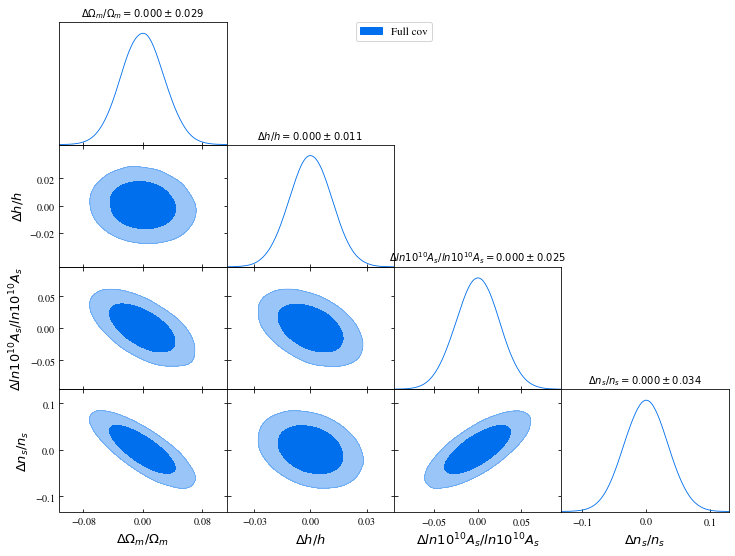

In [54]:
g = plots.get_single_plotter(width_inch=12)
g.triangle_plot([samples], ['rOmega_m', 'rh', 'rlnA_s', 'rn_s'], filled=True, 
                legend_labels = ['Full cov'],
                title_limit=1)
#g.export(os.path.join('fisher', "fisher_0p04-0p2_resc2.pdf"))
plt.show()

In [55]:
np.array([0.023, 0.0093, 0.022, 0.028]) / np.array([0.029, 0.011, 0.025, 0.034])

array([0.79310345, 0.84545455, 0.88      , 0.82352941])

DESI nbar, R + w1 + w2, kmax=0.38

<Figure size 864x648 with 0 Axes>

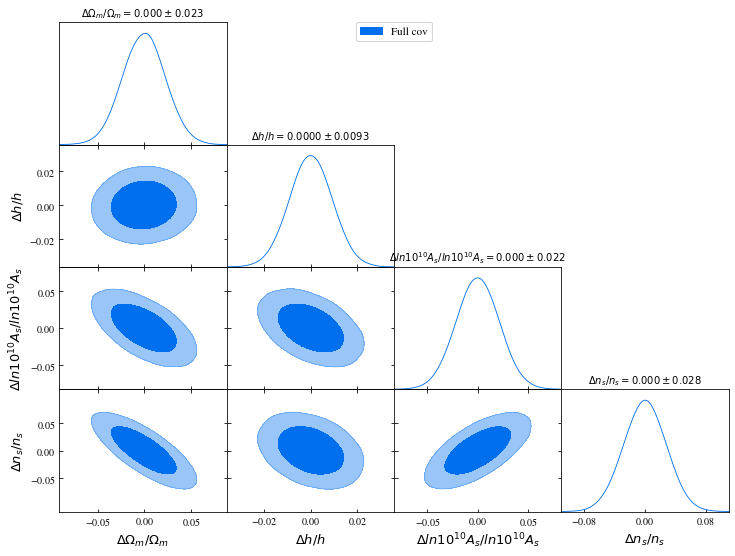

In [32]:
g = plots.get_single_plotter(width_inch=12)
g.triangle_plot([samples], ['rOmega_m', 'rh', 'rlnA_s', 'rn_s'], filled=True, 
                legend_labels = ['Full cov'],
                title_limit=1)
#g.export(os.path.join('fisher', "fisher_0p04-0p2_resc2.pdf"))
plt.show()

In [32]:
parcorr = samples.corr()

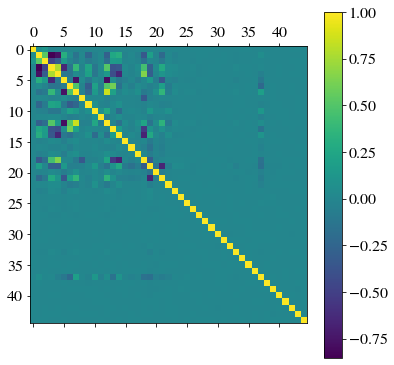

In [33]:
plt.matshow(parcorr)
plt.colorbar()
plt.show()

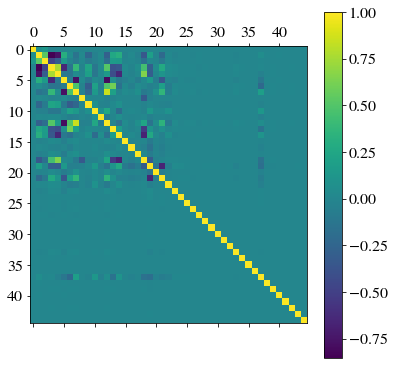

In [34]:
plt.matshow(corr_from_cov(fishcov))
plt.colorbar()
plt.show()

In [60]:
48.876-48.29

0.5859999999999985